In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
# from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
# import xgboost as xgb
# import lightgbm as lgb
from scipy.stats.mstats import winsorize
# from sklearn.tree import DecisionTreeClassifier

# 1. application_ttf_classification_v0
- https://github.com/echosprint/TabularTransformer

## preprocessing_v1.ipynb

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
from google.colab import drive
drive.mount('/content/drive')

# 작업 디렉토리 변경
import os
print(os.getcwd(), end=' -> ')
os.chdir('/content/drive/MyDrive/PatternRecognition/project')
print(os.getcwd())

# CSV 파일 불러오기
df = pd.read_csv('train.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content -> /content/drive/MyDrive/PatternRecognition/project


,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,shares,y
0,17335,9.0,409.0,0.501326,1.0,0.587361,23.0,2.0,11.0,0.0,...,-0.1875,-0.1,0.50,0.500,0.00,0.500,Lifestyle,NaN,801,0
1,21242,10.0,317.0,0.725086,1.0,0.830097,6.0,3.0,NaN,21.0,...,-0.6000,NaN,0.00,0.000,0.50,0.000,Lifestyle,Tuesday,426,0
2,9448,11.0,447.0,0.584091,1.0,0.730104,NaN,1.0,1.0,1.0,...,-0.5000,-0.1,0.75,0.125,0.25,0.125,World,Friday,2400,1
3,36797,13.0,143.0,0.638298,NaN,0.787500,3.0,2.0,NaN,0.0,...,0.0000,0.0,1.00,NaN,0.50,0.500,Social Media,NaN,1100,0
4,29504,17.0,576.0,0.524412,1.0,0.714286,8.0,3.0,NaN,0.0,...,-1.0000,-0.1,0.00,0.000,0.50,0.000,World,Wednesday,1500,1


(0.0, 20000.0)

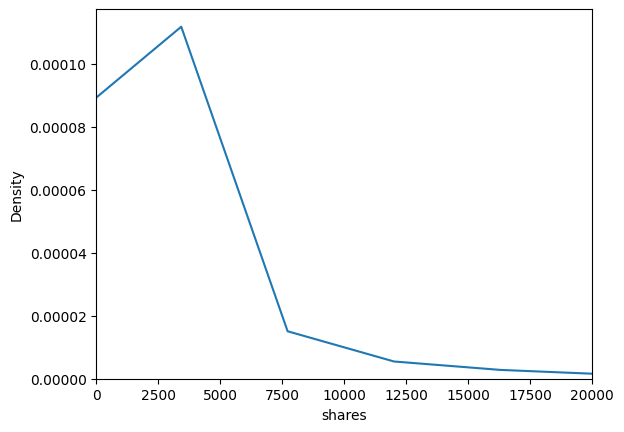

In [61]:
# 공유 수 분포 그래프
sns.kdeplot(df['shares'])
plt.xlim(0, 20000)

In [62]:
# 이상치 제거 비율에 따른 수치 통계

from scipy.stats import skew, kurtosis

quantiles = [1.0, 0.998, 0.995, 0.99, 0.98, 0.975]
summary_list = []

for q in quantiles:
    threshold = df['shares'].quantile(q)
    temp = df[df['shares'] <= threshold]['shares']

    summary = {
        'quantile': q,
        'count': temp.count(),
        'mean': temp.mean(),
        'std': temp.std(),
        'skew': skew(temp),
        'kurtosis': kurtosis(temp),
        'min': temp.min(),
        'max': temp.max()
    }

    summary_list.append(summary)

summary_df = pd.DataFrame(summary_list)
print(summary_df)


   quantile  count         mean           std       skew     kurtosis  min  \
0     1.000  22200  3459.794865  12767.254516  34.564296  1777.645277   22   
1     0.998  22155  3075.768269   5730.182933   6.628787    59.428030   22   
2     0.995  22090  2891.559439   4596.721530   5.102655    34.846652   22   
3     0.990  21978  2694.451224   3655.563807   3.813214    18.020655   22   
4     0.980  21760  2468.876333   2873.139893   3.020613    10.499472   22   
5     0.975  21648  2384.638258   2629.522184   2.816273     8.936662   22   

      max  
0  843300  
1   86200  
2   53100  
3   32100  
4   20400  
5   17300  


(0.0, 8500.0)

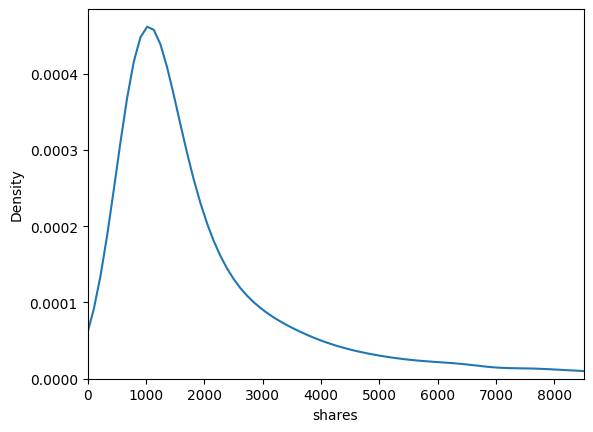

In [63]:
threshold = df['shares'].quantile(0.98)
df = df[df['shares'] <= threshold]

sns.kdeplot(df['shares'])
plt.xlim(0, 8500)

In [64]:
# 가장 많이 등장한 값이 전체에서 차지하는 비율 top 10
top_ratio_dict = {}

for col in df.columns:
    most_common = df[col].value_counts(dropna=False).iloc[0]
    total = len(df)
    ratio = most_common / total
    top_ratio_dict[col] = ratio

top_10 = sorted(top_ratio_dict.items(), key=lambda x: x[1], reverse=True)[:10]

for col, ratio in top_10:
    print(f"{col}: {ratio:.2%}")

kw_max_max: 68.35%
num_videos: 56.65%
kw_min_min: 51.76%
y: 51.45%
abs_title_subjectivity: 46.69%
title_sentiment_polarity: 45.63%
abs_title_sentiment_polarity: 45.57%
num_imgs: 41.48%
title_subjectivity: 40.89%
kw_min_avg: 38.98%


In [65]:
# 중복 값이 많은 변수들을 자세히 살펴보자
df['kw_min_min'].value_counts(dropna=False).head(5)

,count
kw_min_min,
-1.0,11263
4.0,5955
217.0,2323
NaN,2167
0.0,34


In [66]:
df['kw_max_max'].value_counts(dropna=False).head(5)

,count
kw_max_max,
843300.0,14873
NaN,2193
690400.0,1982
617900.0,1115
69100.0,645


In [67]:
df['n_non_stop_words_rounded'] = df['n_non_stop_words'].round(3)  # 소수 셋째 자리까지 반올림
df['n_non_stop_words_rounded'].value_counts(dropna=False)

,count
n_non_stop_words_rounded,
1.0,19041
NaN,2139
0.0,580


In [68]:
# 많은 값들이 같은 값을 가지므로 삭제한다
df.drop(columns=['kw_min_min'], axis=1, inplace=True)
df.drop(columns=['kw_max_max'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words'], axis=1, inplace=True)
df.drop(columns=['n_non_stop_words_rounded'], axis=1, inplace=True)

In [69]:
# 'id'는 각 샘플마다 고유한 값을 가진다. 학습에 사용할 값이 아니므로 삭제한다
df.drop(columns=['id'], axis=1, inplace=True)

In [70]:
# # Scatter plot

X = df.drop(columns=['shares', 'y'])
X = X.select_dtypes(include=['number']) # 숫자형만 필터링
y = df['shares']
target = 'shares'

# # 시각화
# plt.figure(figsize=(18, 20))

# for i, feature in enumerate(X.columns):
#     plt.subplot(7, 6, i + 1)
#     plt.tight_layout(pad=1.5)
#     plt.scatter(X[feature], y, alpha=0.3)
#     plt.xlabel(feature)
#     plt.ylabel(target)

# plt.tight_layout()
# plt.show()

In [71]:
# winsorize
from scipy.stats.mstats import winsorize
feature_with_outliers = ["n_tokens_content", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos", "kw_max_min", "kw_avg_min", "kw_max_avg", "kw_avg_avg", "self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess", "global_rate_positive_words", "global_rate_negative_words", "avg_positive_polarity", "min_positive_polarity"]

# Define the percentile thresholds for Winsorization
lower_percentile = 0.0
upper_percentile = 0.0002

# Apply Winsorization to each input variable
for feature in X.columns:
    if feature in feature_with_outliers:
      X[feature] = winsorize(X[feature], limits=(lower_percentile, upper_percentile))


In [72]:
# 요일별 shares의 평균, 최댓값, 최솟값
weekday_stats = df.groupby('weekday')['shares'].agg(
    avg_shares=lambda x: round(x.mean(), 2),
    max_shares='max',
    min_shares='min'
).reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['weekday'] = pd.Categorical(weekday_stats['weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('weekday')
print(weekday_stats)

     weekday  avg_shares  max_shares  min_shares
1     Monday     2384.82       20300          43
5    Tuesday     2355.24       20400          42
6  Wednesday     2354.53       20300          48
4   Thursday     2357.35       20400          22
0     Friday     2436.35       20400          28
2   Saturday     3117.37       19800          49
3     Sunday     3060.14       20000         171


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21760 entries, 0 to 22199
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                19599 non-null  float64
 1   n_tokens_content              19658 non-null  float64
 2   n_unique_tokens               19541 non-null  float64
 3   n_non_stop_unique_tokens      19549 non-null  float64
 4   num_hrefs                     19565 non-null  float64
 5   num_self_hrefs                19527 non-null  float64
 6   num_imgs                      19587 non-null  float64
 7   num_videos                    19501 non-null  float64
 8   average_token_length          19587 non-null  float64
 9   num_keywords                  19562 non-null  float64
 10  kw_max_min                    19623 non-null  float64
 11  kw_avg_min                    19565 non-null  float64
 12  kw_min_max                    19590 non-null  float64
 13  kw_avg

In [74]:
# 결측치 처리
for col in df.columns:
    if df[col].dtype == 'object': # 범주형 → 최빈값
        df[col] = df[col].fillna(df[col].mode()[0])
    else: # 숫자형 → 중간값
        df[col] = df[col].fillna(df[col].median())

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21760 entries, 0 to 22199
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                21760 non-null  float64
 1   n_tokens_content              21760 non-null  float64
 2   n_unique_tokens               21760 non-null  float64
 3   n_non_stop_unique_tokens      21760 non-null  float64
 4   num_hrefs                     21760 non-null  float64
 5   num_self_hrefs                21760 non-null  float64
 6   num_imgs                      21760 non-null  float64
 7   num_videos                    21760 non-null  float64
 8   average_token_length          21760 non-null  float64
 9   num_keywords                  21760 non-null  float64
 10  kw_max_min                    21760 non-null  float64
 11  kw_avg_min                    21760 non-null  float64
 12  kw_min_max                    21760 non-null  float64
 13  kw_avg

In [76]:
# is_weekend 변수 추가
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 범주형 데이터 One-Hot Encoding
df = pd.get_dummies(df, columns=['data_channel', 'weekday'], drop_first=True)

## train_val_split, Standardization

In [77]:
# X, y 분리
X = df.drop(columns=['shares', 'y'])
y = df['y']
print(X.shape);print(y.shape)

# X_train, X_val, y_train, y_val 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape)

(21760, 53)
(21760,)
(17408, 53)


In [78]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17408 entries, 492 to 16106
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                17408 non-null  float64
 1   n_tokens_content              17408 non-null  float64
 2   n_unique_tokens               17408 non-null  float64
 3   n_non_stop_unique_tokens      17408 non-null  float64
 4   num_hrefs                     17408 non-null  float64
 5   num_self_hrefs                17408 non-null  float64
 6   num_imgs                      17408 non-null  float64
 7   num_videos                    17408 non-null  float64
 8   average_token_length          17408 non-null  float64
 9   num_keywords                  17408 non-null  float64
 10  kw_max_min                    17408 non-null  float64
 11  kw_avg_min                    17408 non-null  float64
 12  kw_min_max                    17408 non-null  float64
 13  kw_a

## application_ttf_classification

In [80]:
# 작업 디렉토리 변경
# import os
print(os.getcwd(), end=' -> ')
os.chdir('/content/')
print(os.getcwd())

/content/drive/MyDrive/PatternRecognition/project -> /content


### import tabular_transformer

In [81]:
!pip install tabular-transformer

In [82]:
import tabular_transformer as ttf
import torch

### 데이터 불러오기 & train val 나누기


- 위에서 했으므로 생략

### file path 설정, data_reader(callable인 DataReader 클래스 객체) 만들기
- train set, val set 따로 하나씩 만들기

In [83]:
# 범주형과 연속형 변수 명시 (X와 y가 합쳐졌을 때 기준)
categorical_cols = ['y']
numerical_cols = X_train.columns.to_list()

In [84]:
# X_train.info()

In [85]:
# X_train.head()

In [86]:
# print(X_train.isna().sum())

In [87]:
# X_train과 X_val의 bool 열을 int 열로 변환
for col in X_train.columns[X_train.dtypes == bool]:
    X_train[col] = X_train[col].astype(int)
for col in X_val.columns[X_val.dtypes == bool]:
    X_val[col] = X_val[col].astype(int)
# X_train.loc[:, X_train.dtypes == bool] = X_train.loc[:, X_train.dtypes == bool].astype(int)
# X_val.loc[:, X_val.dtypes == bool] = X_val.loc[:, X_val.dtypes == bool].astype(int)

In [88]:
# train dataframe, validation dataframe 만들어 저장
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)

# df를 .csv 파일로 /content/에 저장하기
train_df.to_csv("/content/train_dataset.csv", index=False)
val_df.to_csv("/content/val_dataset.csv", index=False)

In [89]:
# file path 설정
train_dataset_path = "/content/train_dataset.csv"
val_dataset_path = "/content/val_dataset.csv"

# DataReader 객체 생성, train과 val에서 하나씩
train_data_reader = ttf.DataReader(
    file_path=train_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols,
    label='y',
    header=True,
    )

val_data_reader = ttf.DataReader(
    file_path=val_dataset_path,
    ensure_categorical_cols=categorical_cols,
    ensure_numerical_cols=numerical_cols,
    label='y',
    header=True,
    )

In [90]:
# iris_dataset_path = ttf.prepare_iris_dataset()

# 구글 드라이브 안의 train.csv 파일을 /content/ 디렉토리에 복사
# !cp /content/drive/MyDrive/PatternRecognition/project/train.csv /content/

# path 설정하기
# train_dataset_path = "/content/train.csv"

### GPU 사용 설정

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() \
    and torch.cuda.is_bf16_supported() else 'float16'
print(device,",", dtype)

cuda , bfloat16


### Training학습 설정, 학습시키기

In [ ]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=64,
                         n_layers=6,
                         n_heads=8,
                         output_hidden_dim=128,
                         output_forward_dim=8,
                         dropout=0.0,
                         weight_decay=0.1,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

In [ ]:
train_tp = ttf.TrainParameters(
    max_iters=1000,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=100,
    eval_iters=100,
    validate_split=0.2,
    learning_rate=5e-4,
    warmup_iters=10,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

### validation

In [ ]:
predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")

In [ ]:
prediction.head(3)

In [ ]:
# 1000번, 웜업 10번
(0.701836 + 0.641613 + 0.6425) / 3

## Parameters Tuning

### 66.1233

In [ ]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=32,
                         n_layers=6,
                         n_heads=8,
                         output_hidden_dim=128,
                         output_forward_dim=8,
                         dropout=0.1,
                         weight_decay=0.1,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=1000,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=5e-4,
    warmup_iters=10,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")
prediction.head(3)

In [ ]:
(70.2205 + 63.9659 + 64.1300) / 3

In [ ]:
# dim 64 -> 32, 1000번
(70.5041+64.4078+64.57) / 3
(70.3034+63.9768+64.09) / 3

66.12339999999999

### 66.2587

In [ ]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=32,
                         n_layers=6,
                         n_heads=8,
                         output_hidden_dim=64,
                         output_forward_dim=8,
                         dropout=0.1,
                         weight_decay=0.1,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=900,
    batch_size=128,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=5e-4,
    warmup_iters=10,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")
prediction.head(3)

In [ ]:
# iter 1000
(70.1017+64.1320+64.34) / 3

66.19123333333333

In [ ]:
# iter 1000->900
(70.1119+64.2344+64.43) / 3

66.25876666666666

### 66.1261

In [93]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=16,
                         n_layers=2,
                         n_heads=2,
                         output_hidden_dim=64,
                         output_forward_dim=8,
                         dropout=0.1,
                         weight_decay=0.1,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=10000,
    batch_size=32,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=10,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")
prediction.head(3)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5102 | epoch 11.7287 | loss 0.6128 |lr 1.454251e-04 | 17.87ms | mfu  0.01%
5103 | epoch 11.7310 | loss 0.6288 |lr 1.453780e-04 | 18.56ms | mfu  0.01%
5104 | epoch 11.7333 | loss 0.6984 |lr 1.453308e-04 | 18.20ms | mfu  0.01%
5105 | epoch 11.7356 | loss 0.5869 |lr 1.452837e-04 | 19.31ms | mfu  0.01%
5106 | epoch 11.7379 | loss 0.5858 |lr 1.452365e-04 | 14.54ms | mfu  0.01%
5107 | epoch 11.7402 | loss 0.7368 |lr 1.451894e-04 | 14.11ms | mfu  0.01%
5108 | epoch 11.7425 | loss 0.7361 |lr 1.451422e-04 | 18.78ms | mfu  0.01%
5109 | epoch 11.7448 | loss 0.6167 |lr 1.450951e-04 | 16.09ms | mfu  0.01%
5110 | epoch 11.7471 | loss 0.6010 |lr 1.450479e-04 | 18.17ms | mfu  0.01%
5111 | epoch 11.7494 | loss 0.7147 |lr 1.450008e-04 | 20.08ms | mfu  0.01%
5112 | epoch 11.7517 | loss 0.5802 |lr 1.449536e-04 | 19.22ms | mfu  0.01%
5113 | epoch 11.7540 | loss 0.7045 |lr 1.449065e-04 | 14.40ms | mfu  0.01%
5114 | epoch 11.7563 | loss 0.5617 |lr 1.448594e-04 | 16.26ms | 

100%|██████████| 5/5 [00:00<00:00, 151.95it/s]

binary cross entropy loss: 0.633280
auc score: 0.699933
f1 macro score: 0.641851
samples: 4352, accuracy: 0.6420
save prediction output to file: out/val_predictions.csv


,prediction,probability
0,1,0.617188
1,1,0.703125
2,0,0.396484


In [45]:
# iter 5,000
(0.698609 + 0.640370 + 0.6413) /3

0.660093

In [49]:
# iter 6,000
(0.699364 + 0.641573 + 0.6418) /3

0.6609123333333332

In [57]:
# iter 8,000
(0.699927 + 0.639686 + 0.6397) /3

0.659771

In [51]:
# iter 10,000
(0.699933 + 0.641851 + 0.6420) /3

0.6612613333333334

In [53]:
# iter 20,000
(0.700015 + 0.634566 + 0.6351) /3

0.6565603333333333

In [55]:
# iter 15,000
(0.699910 + 0.635795 + 0.6363) /3

0.6573349999999999

### 67.0526

In [108]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=64,
                         n_layers=2,
                         n_heads=2,
                         output_hidden_dim=64,
                         output_forward_dim=8,
                         dropout=0.2,
                         weight_decay=0.2,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=10000,
    batch_size=32,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=200,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")
prediction.head(3)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5102 | epoch 11.7287 | loss 0.5417 |lr 1.475249e-04 | 11.67ms | mfu  0.04%
5103 | epoch 11.7310 | loss 0.5549 |lr 1.474773e-04 | 11.47ms | mfu  0.04%
5104 | epoch 11.7333 | loss 0.7201 |lr 1.474297e-04 | 11.78ms | mfu  0.04%
5105 | epoch 11.7356 | loss 0.6386 |lr 1.473821e-04 | 11.47ms | mfu  0.04%
5106 | epoch 11.7379 | loss 0.4813 |lr 1.473345e-04 | 11.24ms | mfu  0.04%
5107 | epoch 11.7402 | loss 0.5599 |lr 1.472870e-04 | 11.19ms | mfu  0.04%
5108 | epoch 11.7425 | loss 0.6496 |lr 1.472394e-04 | 10.82ms | mfu  0.04%
5109 | epoch 11.7448 | loss 0.5507 |lr 1.471918e-04 | 12.60ms | mfu  0.04%
5110 | epoch 11.7471 | loss 0.5709 |lr 1.471442e-04 | 10.96ms | mfu  0.04%
5111 | epoch 11.7494 | loss 0.8081 |lr 1.470966e-04 | 10.82ms | mfu  0.05%
5112 | epoch 11.7517 | loss 0.6126 |lr 1.470490e-04 | 11.20ms | mfu  0.05%
5113 | epoch 11.7540 | loss 0.6718 |lr 1.470014e-04 | 11.38ms | mfu  0.05%
5114 | epoch 11.7563 | loss 0.4595 |lr 1.469538e-04 | 10.64ms | 

100%|██████████| 5/5 [00:00<00:00, 68.64it/s]

binary cross entropy loss: 0.631532
auc score: 0.705214
f1 macro score: 0.642291
samples: 4352, accuracy: 0.6455
save prediction output to file: out/val_predictions.csv


,prediction,probability
0,1,0.589844
1,1,0.625000
2,0,0.326172


In [96]:
# output_forward_dim 8->16
(0.700540 + 0.639352 + 0.6436) /3

0.661164

In [98]:
# dim 16->32
(0.702096 + 0.642249 + 0.6450) /3

0.663115

In [110]:
# dim 16->64
print((0.681214  + 0.622358 + 0.6250) /3)

# dim 64, dropout 0.2, weight_decay 0.2
print((0.704621  + 0.648379 + 0.6514) /3)   # 향상 66.81

# dim 64, dropout 0.2, weight_decay 0.2, output_forward_dim 8->16
print((0.686521  + 0.624985 + 0.6282) /3)       # 저하

# dim 64, dropout 0.2, weight_decay 0.2, warmup_iters 10->100
print((0.705214  + 0.642291 + 0.6455) /3)           # 저하 66.43

# dim 64, dropout 0.2, weight_decay 0.2, warmup_iters 10->200
print((0.705614  + 0.641485 + 0.66448) /3)          # 향상 67.05

0.6428573333333333
0.6681333333333335
0.6465686666666667
0.664335
0.6705263333333334


### .

In [119]:
ts = ttf.TrainSettings(wandb_log=False,
                       device=device,
                       dtype=dtype,
                       apply_power_transform=True,
                       min_cat_count=0.02,
                       dataset_seed=42,
                       torch_seed=42
                       )


hp = ttf.HyperParameters(dim=64,
                         n_layers=2,
                         n_heads=2,
                         output_hidden_dim=64,
                         output_forward_dim=8,
                         dropout=0.2,
                         weight_decay=0.2,
                         beta1=0.9,
                         beta2=0.95
                         )

trainer = ttf.Trainer(hp=hp, ts=ts)

train_tp = ttf.TrainParameters(
    max_iters=10000,
    batch_size=64,
    output_dim=1,
    loss_type='BINCE',
    eval_interval=50,
    eval_iters=50,
    validate_split=0.2,
    learning_rate=3e-4,
    warmup_iters=200,
    lr_scheduler='cosine',
    output_checkpoint='train_ckpt.pt',
    )

trainer.train(
    data_reader=train_data_reader,
    tp=train_tp,
    resume=False
    )

predictor = ttf.Predictor(checkpoint='out/train_ckpt.pt')
prediction = predictor.predict(data_reader=val_data_reader,
                  save_as="val_predictions.csv")
prediction.head(3)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5102 | epoch 23.5115 | loss 0.5506 |lr 1.499038e-04 | 13.01ms | mfu  0.07%
5103 | epoch 23.5161 | loss 0.5662 |lr 1.498557e-04 | 15.30ms | mfu  0.07%
5104 | epoch 23.5207 | loss 0.5995 |lr 1.498077e-04 | 12.35ms | mfu  0.08%
5105 | epoch 23.5253 | loss 0.5996 |lr 1.497596e-04 | 12.92ms | mfu  0.08%
5106 | epoch 23.5300 | loss 0.4872 |lr 1.497115e-04 | 13.12ms | mfu  0.08%
5107 | epoch 23.5346 | loss 0.5131 |lr 1.496634e-04 | 12.73ms | mfu  0.08%
5108 | epoch 23.5392 | loss 0.5712 |lr 1.496153e-04 | 12.98ms | mfu  0.08%
5109 | epoch 23.5438 | loss 0.6906 |lr 1.495672e-04 | 13.12ms | mfu  0.08%
5110 | epoch 23.5484 | loss 0.5461 |lr 1.495191e-04 | 12.63ms | mfu  0.08%
5111 | epoch 23.5530 | loss 0.5124 |lr 1.494711e-04 | 12.72ms | mfu  0.08%
5112 | epoch 23.5576 | loss 0.5270 |lr 1.494230e-04 | 12.92ms | mfu  0.08%
5113 | epoch 23.5622 | loss 0.6368 |lr 1.493749e-04 | 12.66ms | mfu  0.08%
5114 | epoch 23.5668 | loss 0.5769 |lr 1.493268e-04 | 12.74ms | 

100%|██████████| 5/5 [00:00<00:00, 72.41it/s]

binary cross entropy loss: 0.628074
auc score: 0.701396
f1 macro score: 0.646292
samples: 4352, accuracy: 0.6473
save prediction output to file: out/val_predictions.csv


,prediction,probability
0,1,0.589844
1,1,0.601562
2,0,0.312500


In [120]:
# learning rate 3e-4 -> 1e-4
print((0.702405  + 0.641540 + 0.6443) /3)   # 저하

# learning rate 3e-4 -> 5e-4
print((0.702780  + 0.642661 + 0.6457) /3)   # 저하

# n_heads 2->4
print((0.701288  + 0.639846 + 0.6432) /3)   # 저하

# n_layers 2->3
print((0.703263  + 0.646924 + 0.6503) /3)   # 저하

# batch_size 32->64
print((0.701396  + 0.646292 + 0.6473) /3)   # 저하


0.6627483333333334
0.6637136666666668
0.6614446666666667
0.666829
0.664996
